# Data Exploration

This notebook will walk you through different ways we can look at data to gain a better understanding of our data, build intuition, and start hypothesis testing. By the end of this workshop, participants will have some data exploration skills in their toolbox to conduct which lays a solid foundation for any subsequent machine learning or data analysis projects.

Data for this notebook was generated by 'DATA_datasetCompilation.ipynb'. I encourage 

It is assumed that you have two datafiles required stored in 'INPUTS/' folder:
1. CQ_Data_20240602.txt
2. WtshdAttributeTable_20240602.txt

In [850]:
# Import all libraries at the top of your code so you can easily see and organize all the packges you are using. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LinearRegression
os.environ["OMP_NUM_THREADS"] = "11"
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Setting some global parameters based on my preferences
pd.set_option('display.max_columns', None)
plt.rcdefaults()

In [748]:
# Set up the filepaths
inputDataFilepath ='C:/Users/danyk/Work/4_Data_Science/DataExplorationWorkshop/INPUTS/'

In [749]:
# Loading in the concentration, flow, and attribute data.
CQ = pd.read_csv(inputDataFilepath+'CQ_Data_20240604.txt', sep=",", dtype={'SITE': str, 'HUC02': str})
WtshdAtt = pd.read_csv(inputDataFilepath+'WtshdAttributeTable_20240603.txt', sep=",", dtype={'SITE': str, 'HUC02': str})

# Merging CQ data with their watershe attributes
CQ_attrib = CQ.merge(WtshdAtt, on=['SITE','YEAR'], how='left')
CQ_attrib = CQ_attrib.dropna()

## Understanding your watersheds
Before jumping into finding that patterns and trends we see, let's take a look at our data. We want to explore the spatial coverage and type of watersheds that are in our dataset. This step will help guide us on the type of questions or hypothesis we can ask with the data we have.

In [750]:
# Loading in the watershed shapefile. 
wtshd = gpd.read_file(inputDataFilepath+'boundaries-shapefiles-by-aggeco/bas_all.shp')
wtshd = wtshd.rename(columns={'GAGE_ID':'SITE'})
US_boundary = gpd.read_file(inputDataFilepath+'cb_2017_us_state_5m/cb_2017_us_state_5m.shp')
wtshd_f = wtshd[wtshd['SITE'].isin(CQ_attrib['SITE'])]
US_boundary = US_boundary.to_crs(wtshd_f.crs)

(0.0, 3500000.0)

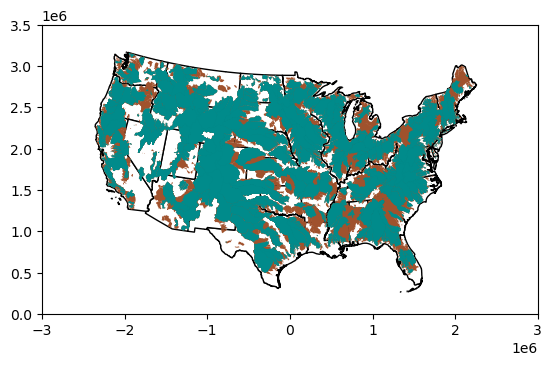

In [751]:
# Let's compare all GAGE watersheds to the dataset that has water quality samples. 

# Task: Plot the watershed shapefile and the filtered watershed shapefile. 
# Syntax: shapefile.plot(ax=[basemap], color='colorName')

# I've plotted the base map, you plot the other 2.
base = US_boundary.plot(color='white', edgecolor='black')

wtshd.plot(ax=base, color='sienna', edgecolor='none')
wtshd_f.plot(ax=base, color='darkcyan', edgecolor='none')
base.set_xlim(-3*10**6, 3*10**6)
base.set_ylim(0, 3.5*10**6)

In [885]:
print(len(wtshd_f))

2594


In [753]:
noYears.head()

YEAR  Conc_Count
0  1980         536
1  1981         482
2  1982         228
3  1983         149
4  1984         130

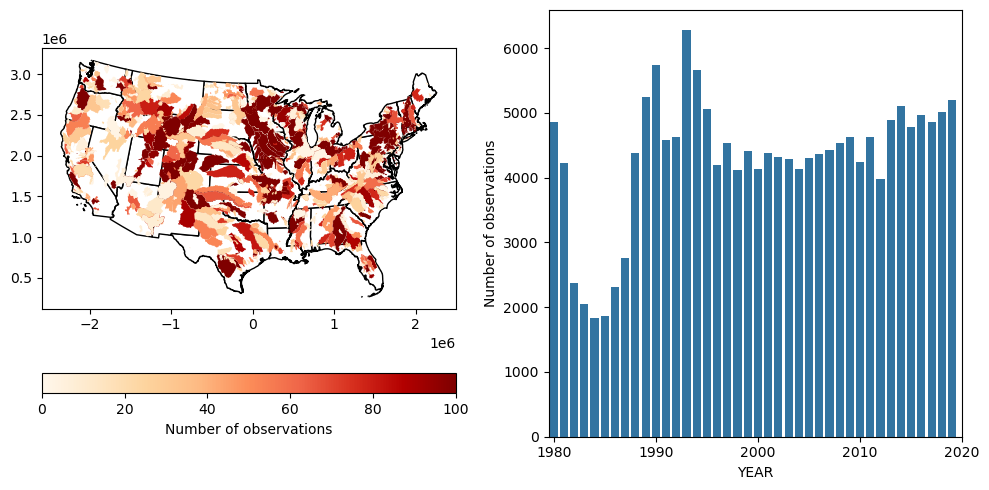

In [754]:
# How many datapoints does each watershed have? What is the distribution of years?
fig, axs = plt.subplots(1,2, figsize=(10, 5))
noWtshd = CQ_attrib.groupby('SITE')['Conc'].count()
noWtshd = wtshd_f.merge(noWtshd, on='SITE')

ax1 = plt.subplot(1,2,1)
US_boundary.plot(color='white', edgecolor='black', ax=ax1)
noWtshd.plot(ax=ax1, 
             column='Conc', 
             cmap='OrRd',
             legend = True,
             vmin=0,
             vmax=100,
             edgecolor='none',
             legend_kwds={"label": "Number of observations", "orientation": "horizontal"})

# Contiguous US
base.set_xlim(-3*10**6, 3*10**6)
base.set_ylim(0, 3.5*10**6)

# What years we do we have in our dataset?
noYears = CQ_attrib.groupby('YEAR')['Conc'].count().reset_index() # Note: reset index turning the index of the Series into a column in the DataFrame
noYears.columns = ['YEAR', 'Conc_Count']

ax2 = plt.subplot(1,2,2)
sns.barplot(data=noYears, x='YEAR', y='Conc_Count', ax=ax2)
ax2.set_ylabel('Number of observations')
ax2.set_xticks(['1980', '1990', '2000', '2010', '2020'])
plt.tight_layout()

That's some decent coverage! We have watersheds across the entire contiguous US, including some of the more data sparse watersheds in the west. 

Let's look at the attributes and understanding the distribution of our data. First we will start with the univariate approach, which just means looking at one variable at a time. There are a few ways to go about this.

- '.describe()' will print out the summary statistics of your variable.
- 'boxplots' can be used to visualize the summary statistics but not the most intuitive to understand the distribution. 
- 'histogram' are great to see the distribution, but understanding the summary statistics can be a challenge.

Using multiple approaches can help get a better understanding of the data. 

In [755]:
CQ_attrib.columns

Index(['SITE', 'NAME', 'AREA_SQKM', 'HUC02', 'LAT', 'LONG', 'STATE', 'CLASS',
       'AGGECOREGION', 'DATE', 'Q_m3s', 'Conc', 'YEAR', 'MONTH', 'UrbLU_pct',
       'NatLU_pct', 'AgLU_pct', 'FERT_kgkm2', 'MANU_kgkm2', 'BFI_AVE',
       'SLOPE_pct', 'AI', 'medianGWD_m', 'TD_pct', 'WWTPd_100km2'],
      dtype='object')

In [756]:
CQ_attrib['AREA_SQKM'].describe()

count    172235.000000
mean       4839.654641
std        8915.804810
min           1.600000
25%         154.800000
50%        1029.300000
75%        3998.600000
max       49802.300000
Name: AREA_SQKM, dtype: float64

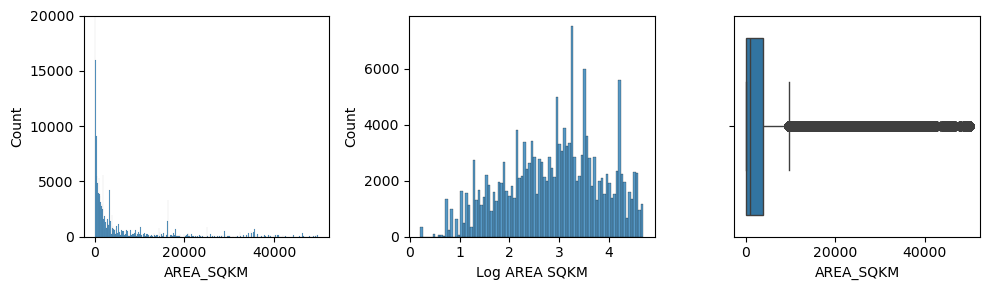

In [757]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))

ax1 = plt.subplot(1,3,1)
sns.histplot(data=CQ_attrib, x="AREA_SQKM", ax=ax1)
ax1.set_ylim(0,20000)

ax2 = plt.subplot(1,3,2)
sns.histplot(x=np.log10(CQ_attrib['AREA_SQKM']), ax=ax2)
plt.tight_layout()
plt.xlabel('Log AREA SQKM')

ax3 = plt.subplot(1,3,3)
sns.boxplot(x=CQ_attrib['AREA_SQKM'], ax=ax3)
plt.tight_layout()

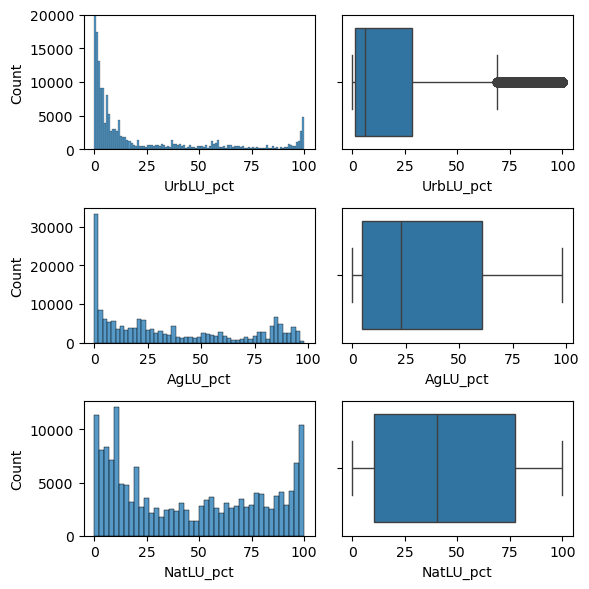

In [758]:
fig, axs = plt.subplots(3,2, figsize=(6, 6))

ax1 = plt.subplot(3,2,1)
sns.histplot(data=CQ_attrib, x="UrbLU_pct", ax=ax1)
ax1.set_ylim(0,20000)

ax2 = plt.subplot(3,2,2)
sns.boxplot(x=CQ_attrib['UrbLU_pct'], ax=ax2)

ax3 = plt.subplot(3,2,3)
sns.histplot(data=CQ_attrib, x="AgLU_pct", ax=ax3)
#ax1.set_ylim(0,40000)

ax4 = plt.subplot(3,2,4)
sns.boxplot(x=CQ_attrib['AgLU_pct'], ax=ax4)

ax5 = plt.subplot(3,2,5)
sns.histplot(data=CQ_attrib, x="NatLU_pct", ax=ax5)
#ax1.set_ylim(0,40000)

ax6 = plt.subplot(3,2,6)
sns.boxplot(x=CQ_attrib['NatLU_pct'], ax=ax6)
plt.tight_layout()

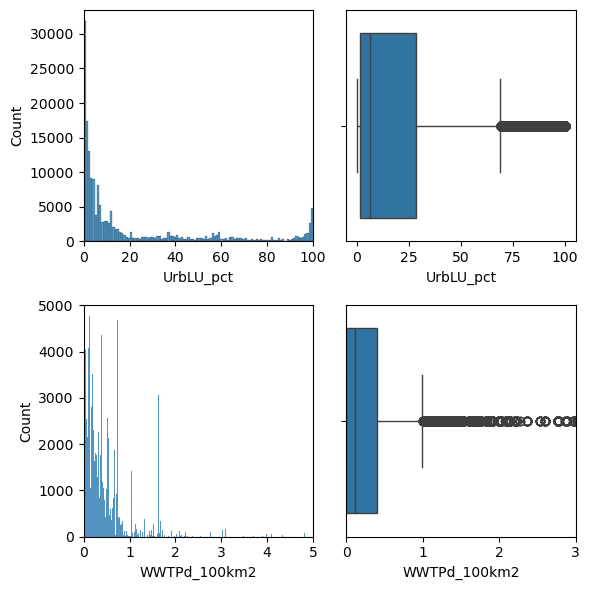

In [759]:
fig, axs = plt.subplots(2,2, figsize=(6, 6))

ax1 = plt.subplot(2,2,1)
sns.histplot(data=CQ_attrib, x="UrbLU_pct", ax=ax1)
ax1.set_xlim(0,100)

ax2 = plt.subplot(2,2,2)
sns.boxplot(x=CQ_attrib['UrbLU_pct'], ax=ax2)

ax3 = plt.subplot(2,2,3)
sns.histplot(data=CQ_attrib, x="WWTPd_100km2", ax=ax3)
ax3.set_xlim(0,5)
ax3.set_ylim(0,5000)

ax4 = plt.subplot(2,2,4)
sns.boxplot(x=CQ_attrib['WWTPd_100km2'], ax=ax4)
ax4.set_xlim(0,3)

plt.tight_layout()

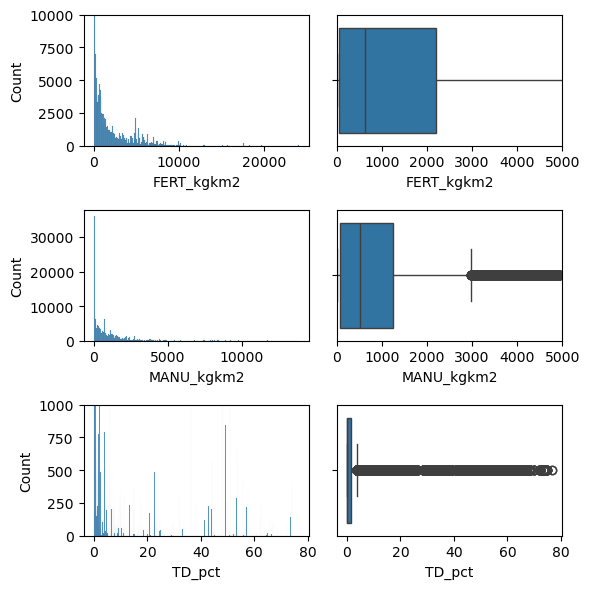

In [760]:
fig, axs = plt.subplots(3,2, figsize=(6, 6))

ax1 = plt.subplot(3,2,1)
sns.histplot(data=CQ_attrib, x="FERT_kgkm2", ax=ax1)
ax1.set_ylim(0,10000)

ax2 = plt.subplot(3,2,2)
sns.boxplot(x=CQ_attrib['FERT_kgkm2'], ax=ax2)
ax2.set_xlim(0,5000)

ax3 = plt.subplot(3,2,3)
sns.histplot(data=CQ_attrib, x="MANU_kgkm2", ax=ax3)
ax4.set_ylim(0,5000)

ax4 = plt.subplot(3,2,4)
sns.boxplot(x=CQ_attrib['MANU_kgkm2'], ax=ax4)
ax4.set_xlim(0,5000)

ax5 = plt.subplot(3,2,5)
sns.histplot(data=CQ_attrib, x="TD_pct", ax=ax5)
ax5.set_ylim(0,1000)

ax6 = plt.subplot(3,2,6)
sns.boxplot(x=CQ_attrib['TD_pct'], ax=ax6)
plt.tight_layout()

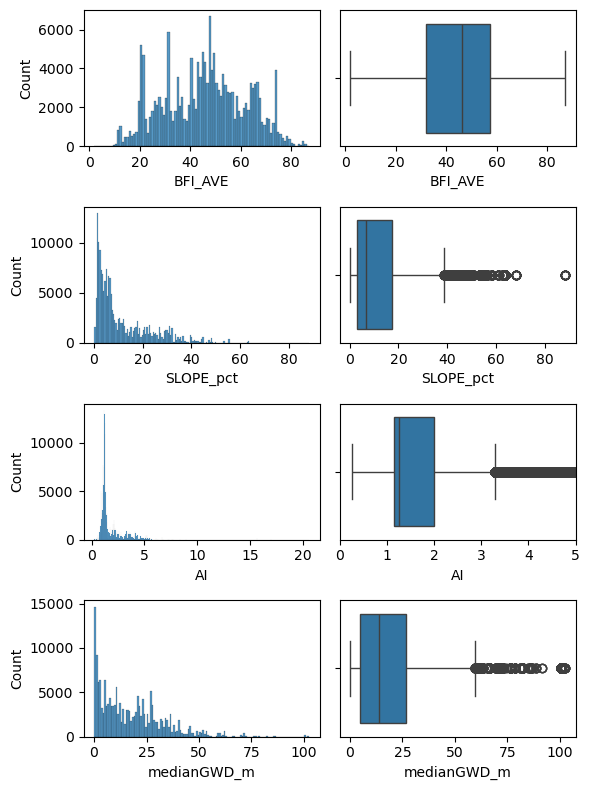

In [761]:
# PLotting the final attributes
fig, axs = plt.subplots(4,2, figsize=(6, 8))

ax1 = plt.subplot(4,2,1)
sns.histplot(data=CQ_attrib, x="BFI_AVE", ax=ax1)

ax2 = plt.subplot(4,2,2)
sns.boxplot(x=CQ_attrib['BFI_AVE'], ax=ax2)

ax3 = plt.subplot(4,2,3)
sns.histplot(data=CQ_attrib, x="SLOPE_pct", ax=ax3)

ax4 = plt.subplot(4,2,4)
sns.boxplot(x=CQ_attrib['SLOPE_pct'], ax=ax4)

ax5 = plt.subplot(4,2,5)
sns.histplot(data=CQ_attrib, x="AI", ax=ax5)

ax6 = plt.subplot(4,2,6)
sns.boxplot(x=CQ_attrib['AI'], ax=ax6)
ax6.set_xlim(0,5)

ax7 = plt.subplot(4,2,7)
sns.histplot(data=CQ_attrib, x="medianGWD_m", ax=ax7)

ax8 = plt.subplot(4,2,8)
sns.boxplot(x=CQ_attrib['medianGWD_m'], ax=ax8)
plt.tight_layout()

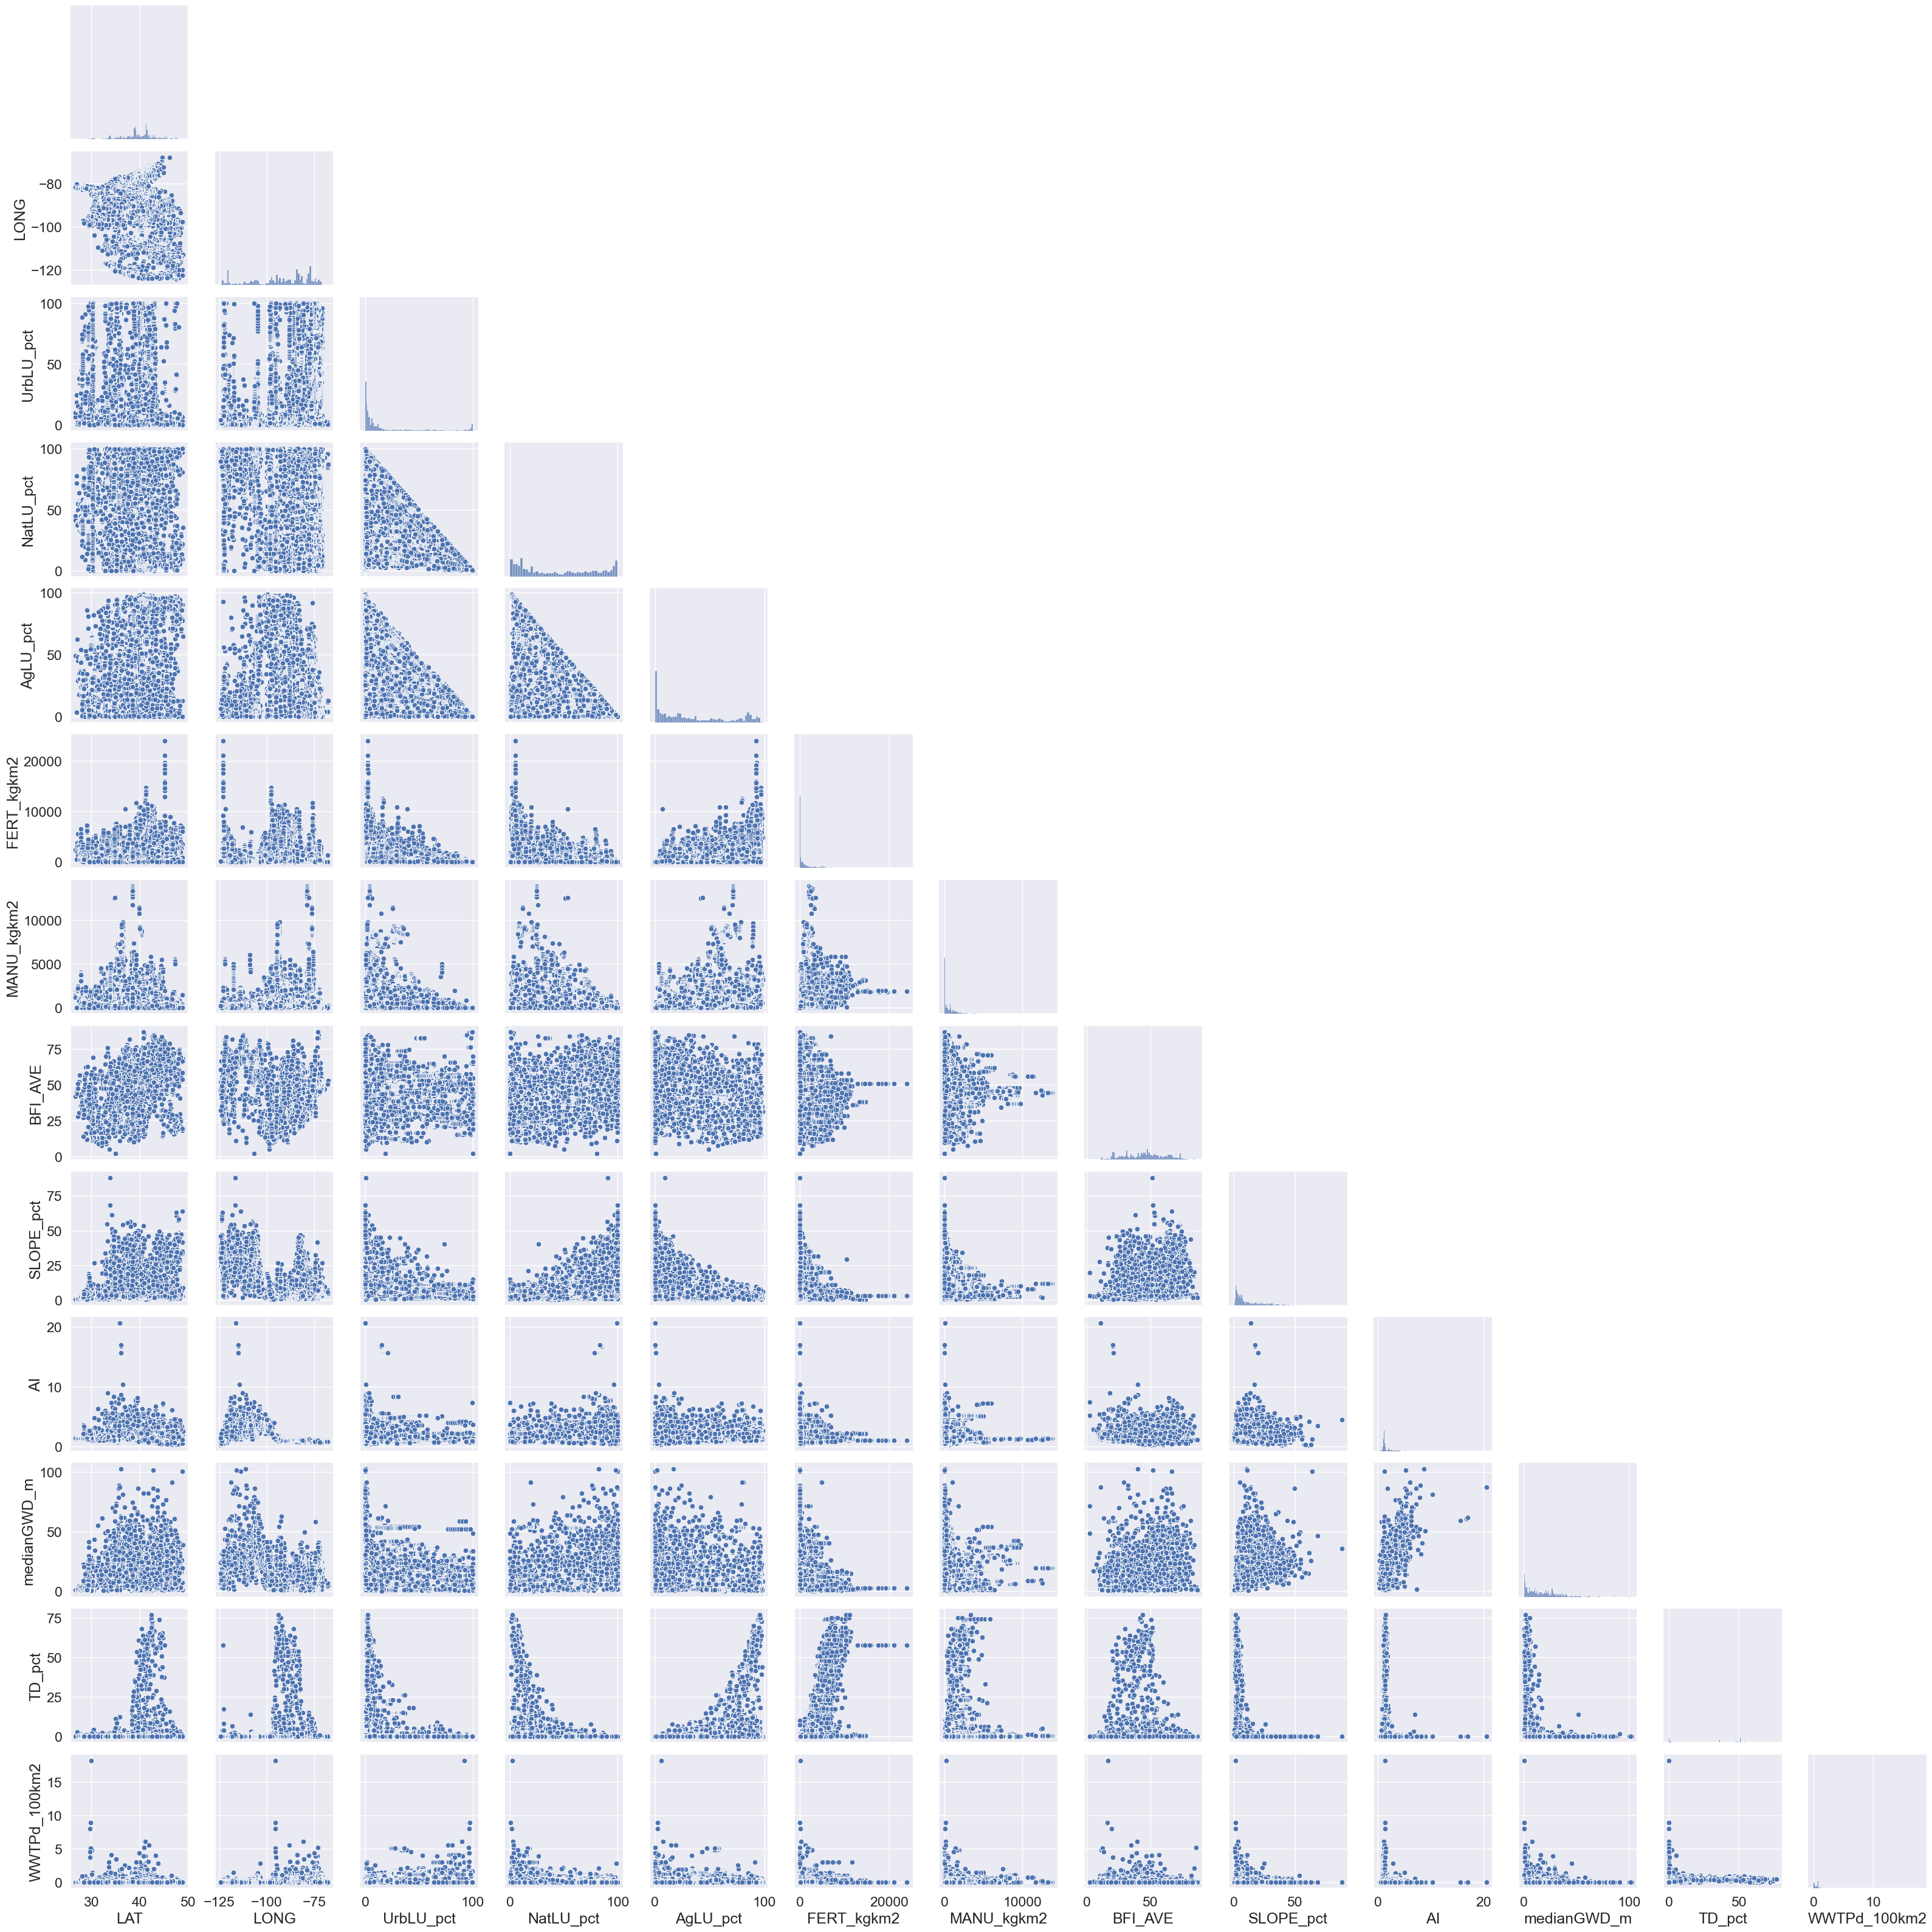

In [762]:
# Now to look at multivariate relationships, pairwise relationships we can make a pairplot of the attributes.
CQ_attrib_filtered = CQ_attrib[['LAT', 'LONG', 'UrbLU_pct', 'NatLU_pct', 'AgLU_pct', 'FERT_kgkm2',
       'MANU_kgkm2', 'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m', 'TD_pct', 'WWTPd_100km2']]
sns.set(font_scale=1.5)
sns.pairplot(CQ_attrib_filtered, corner=True)

### What do we see?
- Latitude and Longitude and not highly correlated with the other features
- Slope is correlated with agricultural LU and inputs
- Land use has some correlated relationships
- Land use and lat and long are not correlated, so there is no spatial correlation with land use
- AI/GWD and TD are correlated
- Wastewater treatment plant density
- Urban LU and WWTP density are not highly correlated
- Fertilizer and manure correlated with WWTP density

Text(0.5, 3.722222222222216, 'Log Flow rate')

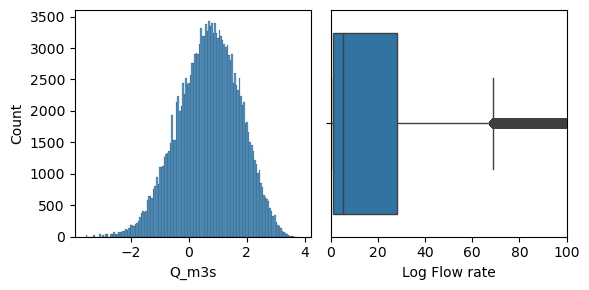

In [763]:
# Now let's look at the flows and concentrations!
plt.rcdefaults()

fig, axs = plt.subplots(1,2, figsize=(6, 3))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=np.log10(CQ_attrib['Q_m3s']), ax=ax1)

ax2 = plt.subplot(1,2,2)
sns.boxplot(data=CQ_attrib, x="Q_m3s", ax=ax2)
ax2.set_xlim(0,100)

plt.tight_layout()
plt.xlabel('Log Flow rate')

In [764]:
CQ_attrib['Q_m3s'].describe()

count    172235.000000
mean         49.987024
std         167.728213
min           0.000283
25%           0.957109
50%           5.408518
75%          28.118629
max        6796.043182
Name: Q_m3s, dtype: float64

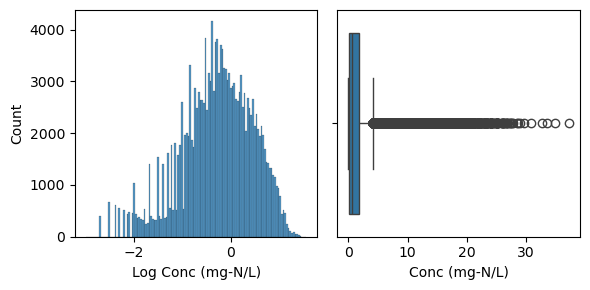

In [765]:
fig, axs = plt.subplots(1,2, figsize=(6, 3))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=np.log10(CQ_attrib['Conc']), ax=ax1)
plt.xlabel('Log Conc (mg-N/L)')

ax2 = plt.subplot(1,2,2)
sns.boxplot(data=CQ_attrib, x="Conc", ax=ax2)
plt.xlabel('Conc (mg-N/L)')
plt.tight_layout()

In [766]:
CQ_attrib['Conc'].describe()

count    172235.000000
mean          1.575115
std           2.507645
min           0.001000
25%           0.189000
50%           0.580000
75%           1.800000
max          37.200000
Name: Conc, dtype: float64

(0.0, 3500000.0)

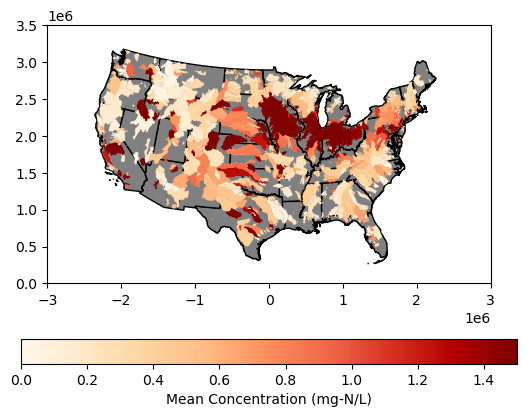

In [767]:
# Where are the highest concentrations?
meanC = CQ_attrib.groupby('SITE')['Conc'].mean().reset_index()
meanC_shp = wtshd_f.merge(meanC, on='SITE')

base = US_boundary.plot(color='grey', edgecolor='black')

meanC_shp.plot(ax=base, 
               column='Conc', 
               cmap='OrRd',
               legend = True,
               vmin=0,
               vmax=1.5,
               edgecolor='none',
               legend_kwds={"label": "Mean Concentration (mg-N/L)", "orientation": "horizontal"})

# Contiguous US
base.set_xlim(-3*10**6, 3*10**6)
base.set_ylim(0, 3.5*10**6)

# Midwest
#base.set_xlim(-0.5*10**6, 1.25*10**6)
#base.set_ylim(1.5*10**6, 3*10**6)

# Western US
#base.set_xlim(-3*10**6,0.5*10**6)
#base.set_ylim(0.5*10**6, 2.25*10**6)

## Developping research questions
Working with open data is faster than doing your own data collection, however you might not know whether the data you need is available and what your data is able to show. 
Resolution (spatial and temporal) can limit what you are able to answer. Data available can limit what you are able to answer. 

Most of my research projects aren't approached using the traditional hypothesis testing approach. To make sure I don't spend too much time trying to make my data fit my needs, I try to use the data to guide what questions I _can_ answer. 

**Summary of data:** 
- Watersheds cover the spatial coverage
- Land use skews towards natural but there is also many sites that have urban and agricultural stressors
- Other characteristics, including GW depth and aridity index has a good spread. 
- Range of drainage area (1e1 to 1e4)
- Agricultural land use and tile drainage are correlated but not strongly.
- There aren't too many highly tile-drained watersheds

**Questions we may begin to ask:**
- Relationship betwen X characteristic impact mean concentration?
- How is the relationship between C and Q differ across space and time?
    - How does watershed-scale (area) influence this CQ relationship?
    - How does human-management of the landscape influence this relationship?
 
### Concentration-Discharge Relationships
CQ relationships, which describe the relationship between solute concentration (C) and discharge (Q), have been used for years to understand the underlying drivers of catchment export dynamics. These relationships are valuable for interpreting the processes driving export patterns of solutes.

Different typologies of CQ relationships provide integrated signals of processes hapenning within the catchment. 

Some fundational literature on CQ relationships in human-impacted landscapes:
- [Musolff, A., Schmidt, C., Selle, B., & Fleckenstein, J. H. (2015). Catchment controls on solute export. Advances in Water Resources, 86, 133–146.](https://www.sciencedirect.com/science/article/abs/pii/S030917081500233X)
- [Basu, N. B., Destouni, G., Jawitz, J. W., Thompson, S. E., Loukinova, N. V., Darracq, A., Zanardo, S., Yaeger, M., Sivapalan, M., Rinaldo, A., & Rao, P. S. C. (2010). Nutrient loads exported from managed catchments reveal emergent biogeochemical stationarity. Geophysical Research Letters, 37(23).](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010GL045168)
- [Speir, S. L., Rose, L. A., Blaszczak, J. R., Kincaid, D. W., Fazekas, H. M., Webster, A. J., Wolford, M. A., Shogren, A. J., & Wymore, A. S. (2024). Catchment concentration–discharge relationships across temporal scales: A review. WIREs. Water, 11(2). https://doi.org/10.1002/wat2.1702](https://wires.onlinelibrary.wiley.com/doi/full/10.1002/wat2.1702)

### Feature Engineering
Feature engineering is the fancy name for the process of transforming raw data into new features (attributes) to gain better insights on the data. You will hear this term a lot in the machine learning space, because it's a key step to improving model performance. 

One feature that we will generating is is the C-Q Slope (β):
β is the exponent of a power-law equation (C = aQ^β). We can find this slope by regressing C and Q in the log-log space.


![CQ-relationship by Speirs et al.](../INPUTS/schematics/CQ_relationship.png)

(figure recreated from Speirs et al.)

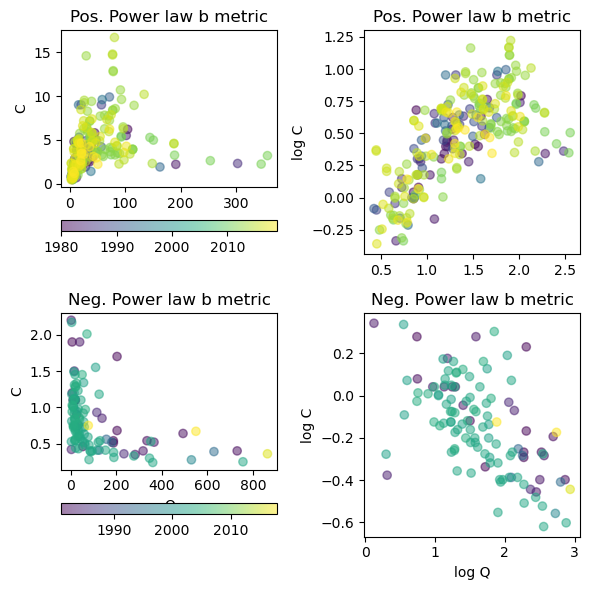

In [768]:
# Let's take a look at how this looks with real data
fig, axs = plt.subplots(2,2, figsize=(6, 6))

CQ_Site = CQ_attrib.loc[CQ_attrib['SITE'] == '04176500']
plt1 = axs[0, 0].scatter(data=CQ_Site, x='Q_m3s', y='Conc', c='YEAR',alpha=0.5)
axs[0, 1].scatter(x=np.log10(CQ_Site['Q_m3s']), y=np.log10(CQ_Site['Conc']), c=CQ_Site['YEAR'],alpha=0.5)
plt.colorbar(plt1, ax=axs[0, 0], orientation ='horizontal')
axs[0, 0].set_title('Pos. Power law b metric')
axs[0, 1].set_title('Pos. Power law b metric')

CQ_Site = CQ_attrib.loc[CQ_attrib['SITE'] == '02096960']
plt2 = axs[1, 0].scatter(data=CQ_Site, x='Q_m3s', y='Conc', c='YEAR',  alpha=0.5)
axs[1, 1].scatter(x=np.log10(CQ_Site['Q_m3s']), y=np.log10(CQ_Site['Conc']), c=CQ_Site['YEAR'],alpha=0.5)
plt.colorbar(plt2, ax=axs[1, 0], orientation ='horizontal')
axs[1, 0].set_title('Neg. Power law b metric')
axs[1, 1].set_title('Neg. Power law b metric')

axs[0, 0].set_ylabel('C')
axs[0, 1].set_ylabel('log C')
axs[1, 0].set_ylabel('C')
axs[1, 1].set_ylabel('log C')

axs[1, 0].set_xlabel('Q')
axs[1, 1].set_xlabel('log Q')

plt.tight_layout()

In [769]:
def fit_PowerLaw(group):
    X = np.log(group['Q_m3s']).values.reshape(-1, 1)
    y = np.log(group['Conc']).values
    model = LinearRegression()
    model.fit(X, y)
    group['b'] = model.coef_[0]
    return group

# Apply the log-transformed linear regression function to each group. Add as a columns.
CQ_attrib = CQ_attrib.groupby('SITE').apply(fit_PowerLaw, include_groups=False).reset_index(level=0)

In [770]:
# Summarize the dataframe with all mean values.
CQ_attrib_mean = CQ_attrib.groupby('SITE').agg({'AREA_SQKM':'first', 
                                                'HUC02':'first', 
                                                'Q_m3s':'mean',
                                                'Conc': 'mean', 
                                                 'b': 'first',
                                                 'UrbLU_pct':'mean',
                                                 'NatLU_pct':'mean',
                                                 'AgLU_pct':'mean',
                                                 'FERT_kgkm2':'mean',
                                                 'MANU_kgkm2':'mean',
                                                 'BFI_AVE':'first',
                                                 'SLOPE_pct':'first',
                                                 'AI':'first',
                                                 'medianGWD_m':'first',
                                                 'TD_pct':'first',
                                                 'WWTPd_100km2':'first'}).reset_index()

### Spatial pattern of CQ relationships

(0.0, 3500000.0)

<Figure size 2000x2000 with 0 Axes>

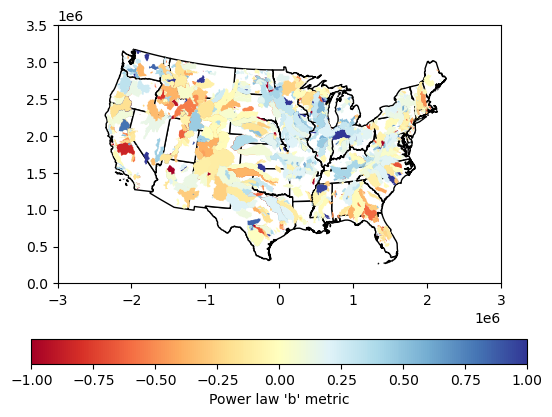

In [771]:
# Start by looking at the spatial distribution of the 'b' metric
b_shp = wtshd_f.merge(CQ_attrib_mean, on='SITE')

plt.figure(figsize=(20,20))
base = US_boundary.plot(color='white', edgecolor='black')
b_shp.plot(ax=base,
           column='b', 
           cmap='RdYlBu',
           legend =  True,
           vmin=-1,
           vmax=1,
           edgecolor='none',
           legend_kwds={"label": "Power law 'b' metric", "orientation": "horizontal"})

base.set_xlim(-3*10**6, 3*10**6)
base.set_ylim(0, 3.5*10**6)

We can see that **enrichment** slope (positive b) is more common in the midwest. Outside of this region we see a lot more **dilution export**.

Doing another round of 'b metric' vs. watershed properties could help us understand the drivers of these export patterns. 

In [772]:
# Which attributes would you like to plot?
CQ_attrib.columns

Index(['SITE', 'NAME', 'AREA_SQKM', 'HUC02', 'LAT', 'LONG', 'STATE', 'CLASS',
       'AGGECOREGION', 'DATE', 'Q_m3s', 'Conc', 'YEAR', 'MONTH', 'UrbLU_pct',
       'NatLU_pct', 'AgLU_pct', 'FERT_kgkm2', 'MANU_kgkm2', 'BFI_AVE',
       'SLOPE_pct', 'AI', 'medianGWD_m', 'TD_pct', 'WWTPd_100km2', 'b'],
      dtype='object')

Text(0.5, 0, 'Attribute')

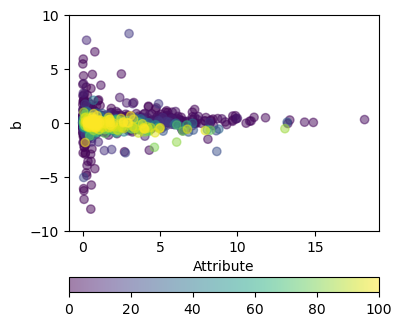

In [773]:
# Let's take a look at how this looks with real data
#fig, axs = plt.subplots(2,2, figsize=(6, 6))
plt.figure(figsize=(4, 4))

# Toggle the attributes
attribute = 'UrbLU_pct'

CQ_attrib_mean = CQ_attrib_mean.sort_values(by=[attribute])
plt.scatter(data=CQ_attrib_mean, x='Conc', y='b',c = attribute, alpha=0.5)
plt.colorbar(orientation ='horizontal')
plt.ylim(-10,10)
plt.ylabel('b')
plt.xlabel('Attribute')

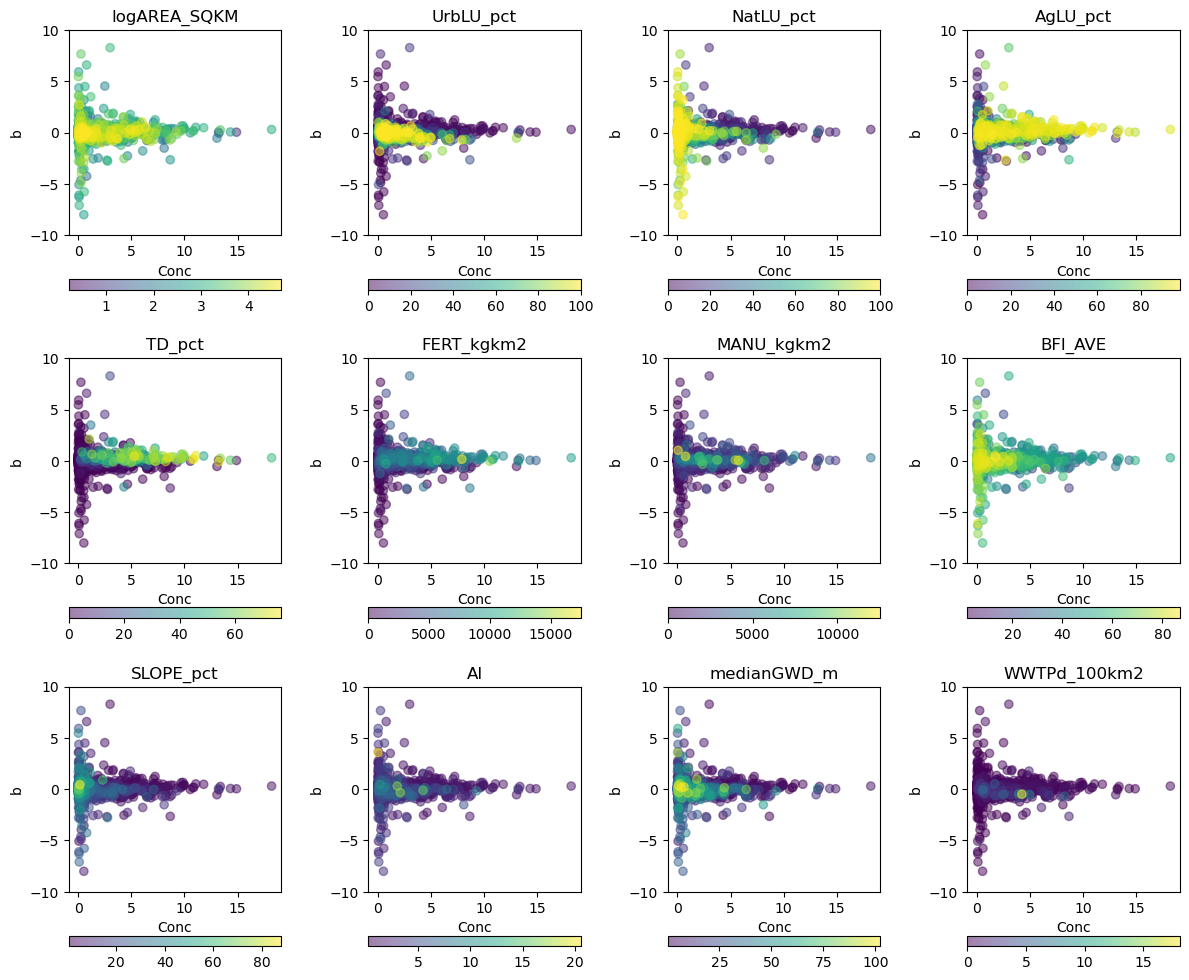

In [774]:
CQ_attrib_mean['logAREA_SQKM'] = np.log10(CQ_attrib_mean['AREA_SQKM'])
attributes =  ['logAREA_SQKM', 'UrbLU_pct', 'NatLU_pct', 'AgLU_pct', 'TD_pct', 'FERT_kgkm2',
       'MANU_kgkm2', 'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m','WWTPd_100km2']

fig, axs = plt.subplots(3, 4, figsize=(12, 10))

for ax, attribute in zip(axs.flatten(), attributes):
    CQ_attrib_mean = CQ_attrib_mean.sort_values(by=[attribute])
    sc = ax.scatter(data=CQ_attrib_mean, x='Conc', y='b', c=CQ_attrib_mean[attribute], cmap='viridis', alpha=0.5)
    fig.colorbar(sc, ax=ax, orientation='horizontal')
    ax.set_ylim(-10, 10)
    ax.set_ylabel('b')
    ax.set_xlabel('Conc')
    ax.set_title(attribute)

plt.tight_layout()
plt.show()

Overall, there are some patterns but nothing overly telling. This is just the nature of messy environmental data. 

Some things that we can see: 
- Larger watershed are less dynamic (b = 0), perhaps because of competing signals. 
- Natural land use is more dynamic (b < 0, b > 0)
- Agricultural land use is more constant (b = 0)
- Of the agricultural land use, watersheds with more tile drainage appear to make up the agricultural watesheds with constant export regime.

In [775]:
CQ_attrib.head(3)

SITE                                              NAME  AREA_SQKM  \
0  01017960  Meduxnekeag R above S Br Medux. R nr Houlton, ME      226.3   
1  01017960  Meduxnekeag R above S Br Medux. R nr Houlton, ME      226.3   
2  01017960  Meduxnekeag R above S Br Medux. R nr Houlton, ME      226.3   

  HUC02     LAT       LONG STATE    CLASS AGGECOREGION        DATE     Q_m3s  \
0    01  46.105 -67.881389    ME  Non-ref    NorthEast  2005-06-23  3.426338   
1    01  46.105 -67.881389    ME  Non-ref    NorthEast  2005-08-10  0.455901   
2    01  46.105 -67.881389    ME  Non-ref    NorthEast  2005-09-15  0.385109   

   Conc  YEAR  MONTH  UrbLU_pct  NatLU_pct  AgLU_pct  FERT_kgkm2  MANU_kgkm2  \
0  0.09  2005      6      2.369     84.703    12.888      1469.7       36.54   
1  0.04  2005      8      2.369     84.703    12.888      1469.7       36.54   
2  0.06  2005      9      2.369     84.703    12.888      1469.7       36.54   

     BFI_AVE  SLOPE_pct      AI  medianGWD_m    TD_pct  WWTPd_100km2         b  
0  51.614035   6.801414  0.8544     4.867628  0.376703           0.0  0.276474  
1  51.614035   6.801414  0.8544     4.867628  0.376703           0.0  0.276474  
2  51.614035   6.801414  0.8544     4.867628  0.376703           0.0  0.276474

## Dimension reduction to understand how watersheds are similar. 
Trying to understand export behaviours with 12 different drivers and their interactions over 50 years can be challenging. One tool we can use to simplify this is to perform dimension reduction by applying unsupervised machine learning.

We will apply k-means clustering which will group together events that have similar export patterns. 

The first step is to normalize the data, which involves choosing a method. Recall the distributions of the data. Many features had high extremes which will pose issues for k-means distance measure.  For simplicity, we will just have set an upper limit on the values and then linearly transform them between 0 and 1.

In [776]:
def linearNormalization(data, feature, min_val=None, max_val=None):
    if min_val is not None:
        data[feature] = np.maximum(data[feature], min_val)
    if max_val is not None:
        data[feature] = np.minimum(data[feature], max_val)
        
    min_val = data[feature].min()
    max_val = data[feature].max()
    data[feature] = (data[feature] - min_val) / (max_val - min_val)

In [794]:
# Isolate the attributes we want to use in our clustering algorithm 
CQ_attrib['logAREA_SQKM'] = np.log10(CQ_attrib['AREA_SQKM'])
attributes =  ['Conc', 'logAREA_SQKM', 'UrbLU_pct', 'NatLU_pct', 'AgLU_pct', 'TD_pct', 'FERT_kgkm2',
               'MANU_kgkm2', 'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m', 'WWTPd_100km2', 'b']
kMeans_data = CQ_attrib[attributes].copy()

# Normalizing the data that do not have upper limits. 
max_values = {
    'Conc': 10,
    'FERT_kgkm2': 5000,
    'MANU_kgkm2': 5000,
    'SLOPE_pct':100, 
    'AI':2, 
    'medianGWD_m':30, 
    'WWTPd_100km2':1,
    'b':2}
min_values = {'b':-2}


for feature in attributes:
    min_val = min_values.get(feature)
    max_val = max_values.get(feature)
    linearNormalization(kMeans_data, feature, min_val, max_val)

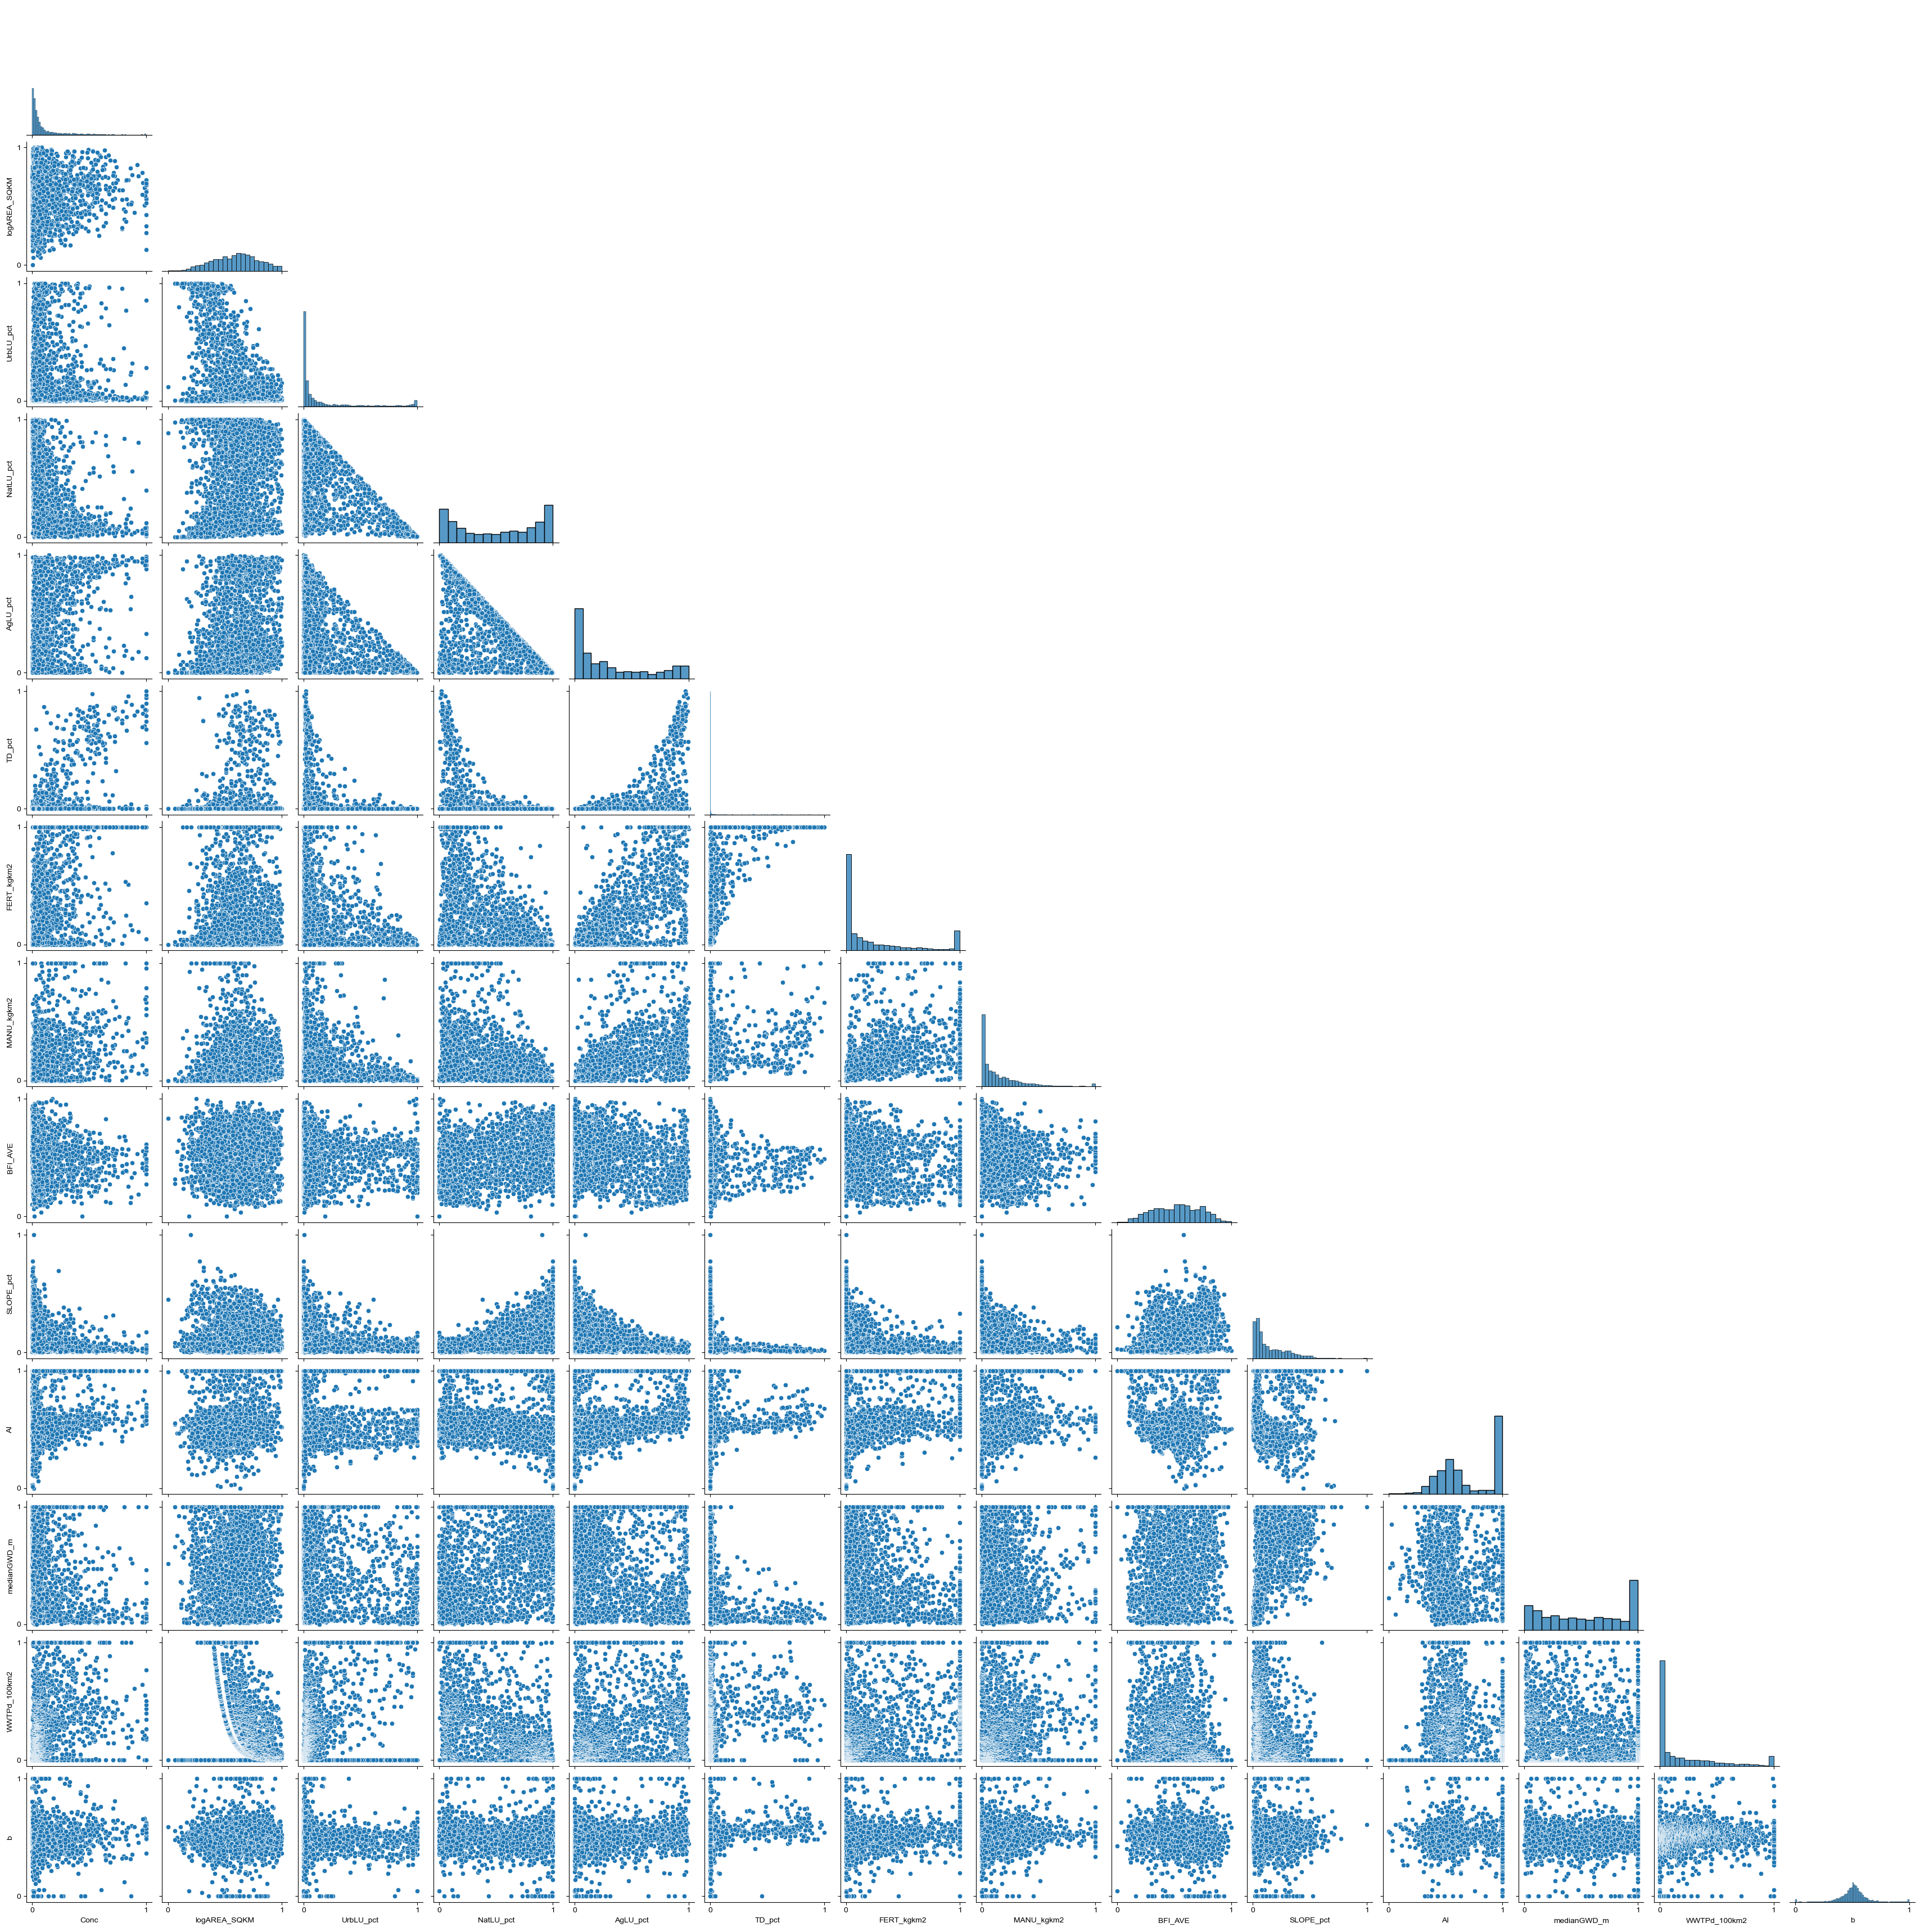

In [778]:
sns.pairplot(kMeans_data, corner=True)
sns.set(font_scale=3)

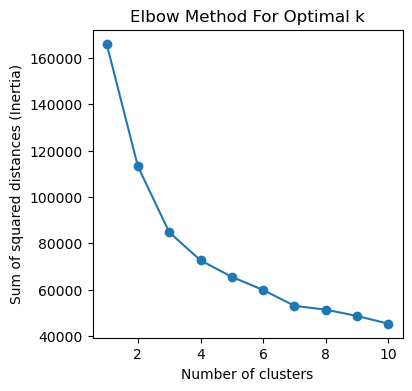

In [795]:
# Reset defaults
plt.rcdefaults()

# We need to tune the k hyperparameter to find the optimal number of clusters. 
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kMeans_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(4, 4))
plt.plot(range(1, 11, 1), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [815]:
# Choosing 'k' is a subjective choice. 
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(kMeans_data)

# Add cluster labels to the original dataset
CQ_attrib['Cluster'] = kmeans.labels_
def cust_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan
CQ_attrib_modeClust = CQ_attrib.groupby('SITE').agg({'logAREA_SQKM':'first', 
                                            'HUC02':'first', 
                                            'Q_m3s':'mean',
                                            'Conc': 'mean', 
                                            'b': 'first',
                                            'UrbLU_pct':'mean',
                                            'NatLU_pct':'mean',
                                            'AgLU_pct':'mean',
                                            'FERT_kgkm2':'mean',
                                            'MANU_kgkm2':'mean',
                                            'BFI_AVE':'first',
                                            'SLOPE_pct':'first',
                                            'AI':'first',
                                            'medianGWD_m':'first',
                                            'TD_pct':'first',
                                            'WWTPd_100km2':'first',
                                           'Cluster':cust_mode}
                                            ).reset_index()

CQ_attrib_modeClust['Cluster'] = CQ_attrib_modeClust['Cluster'].astype('category')
CQ_attrib_modeClust.head()

SITE  logAREA_SQKM HUC02       Q_m3s      Conc         b  UrbLU_pct  \
0  01017960      2.354685    01    1.422450  0.063333  0.276474   2.369000   
1  01018000      2.653695    01    3.036510  0.592222 -0.443951   2.047333   
2  01022260      2.209515    01    2.619308  0.010000  0.000000   0.170000   
3  01022500      2.758609    01   10.691456  0.070435  0.201806   0.330696   
4  01049265      4.146587    01  274.919805  0.167299  0.000298   2.922104   

   NatLU_pct   AgLU_pct   FERT_kgkm2  MANU_kgkm2    BFI_AVE  SLOPE_pct  \
0  84.703000  12.888000  1469.700000   36.540000  51.614035   6.801414   
1  86.216333  11.716333  1355.522222   32.157778  51.929360   5.244051   
2  87.120000  12.710000   101.200000  192.400000  52.830189   4.705224   
3  95.927217   3.722087    31.300000   59.439130  50.612565   5.484014   
4  93.120597   3.923091    68.371429  199.809870  47.180916   9.312341   

         AI  medianGWD_m    TD_pct  WWTPd_100km2 Cluster  
0  0.854400     4.867628  0.376703         0.000       6  
1  0.851331     3.952087  0.323262         0.000       6  
2  0.791164     4.974441  0.005560         0.000       6  
3  0.792992     6.584268  0.099948         0.000       6  
4  0.820537     9.010452  0.064314         0.121       6

# Start by looking at the spatial distribution of the 'b' metric
b_shp = wtshd_f.merge(CQ_attrib_modeClust, on='SITE')
print(b_shp['Cluster'].unique())
plt.figure(figsize=(20,20))
base = US_boundary.plot(color='white', edgecolor='black')
b_shp.plot(ax=base,
           cmap='RdYlBu',
           legend =  True)

base.set_xlim(-3*10**6, 3*10**6)
base.set_ylim(0, 3.5*10**6)

In [ ]:
CQ_attrib_long = pd.melt(CQ_attrib_modeClust, id_vars='Cluster', 
                         value_vars=['Conc', 'logAREA_SQKM', 'b', 'UrbLU_pct', 
                                     'NatLU_pct', 'AgLU_pct', 'FERT_kgkm2', 'MANU_kgkm2', 
                                     'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m', 
                                     'TD_pct', 'WWTPd_100km2'],
                         var_name='Attribute', value_name='Value')

attributes = ['logAREA_SQKM', 'Conc', 'UrbLU_pct', 
              'NatLU_pct', 'AgLU_pct', 'TD_pct', 'FERT_kgkm2', 'MANU_kgkm2', 
              'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m', 'WWTPd_100km2','b']

# Number of rows and columns for subplots
n_rows = 2
n_cols = 7

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,6), constrained_layout=True)
axes = axes.flatten()

# Plot each attribute in a separate subplot
palette = sns.color_palette("RdYlBu",8)
for i, attribute in enumerate(attributes):
    sns.boxplot(x='Cluster', 
                y='Value', 
                data=CQ_attrib_long[CQ_attrib_long['Attribute'] == attribute], 
                ax=axes[i], 
                showfliers=False,
               palette=palette,
               hue='Cluster',
               legend=False)
    axes[i].set_title(attribute)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Value')

# Remove any empty subplots (if any)
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.show()

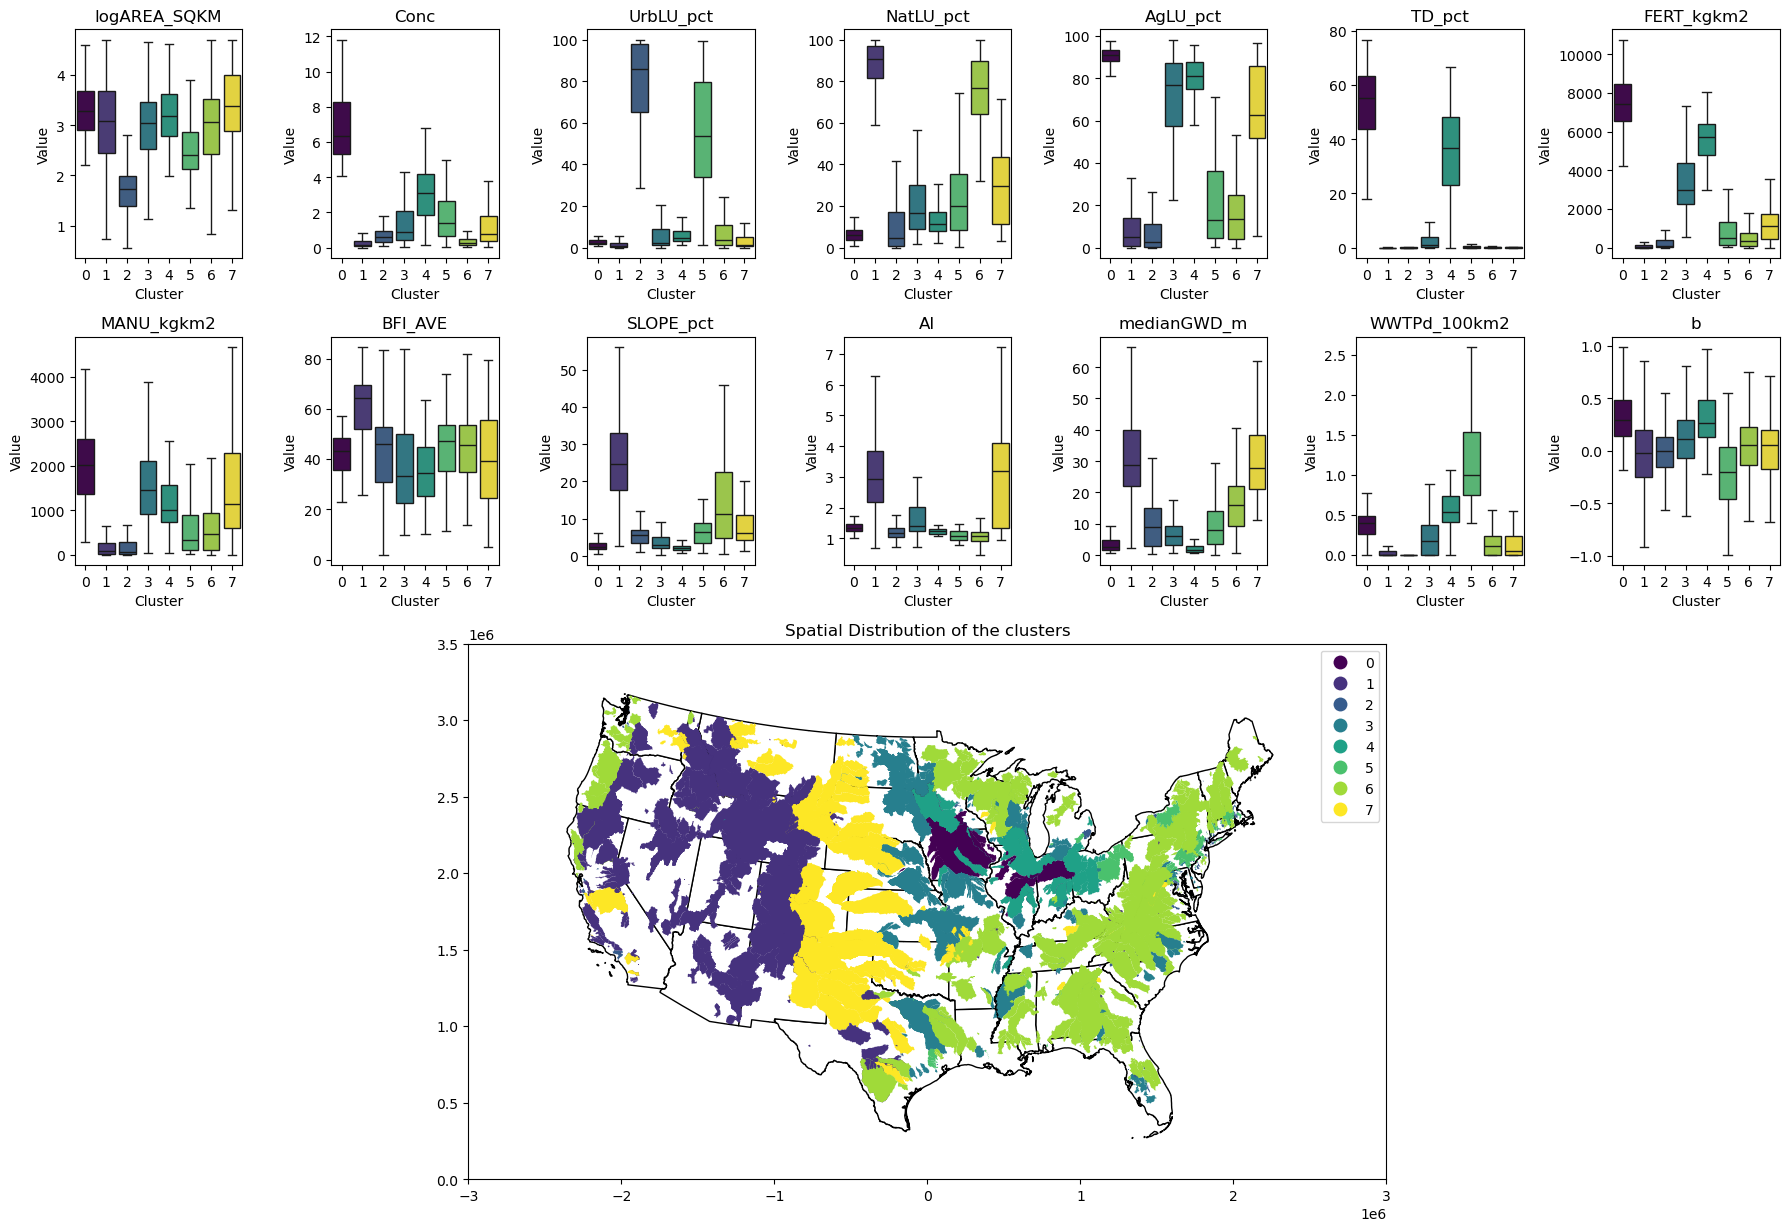

In [888]:
CQ_attrib_long = pd.melt(CQ_attrib_modeClust, id_vars='Cluster', 
                         value_vars=['Conc', 'logAREA_SQKM', 'b', 'UrbLU_pct', 
                                     'NatLU_pct', 'AgLU_pct', 'FERT_kgkm2', 'MANU_kgkm2', 
                                     'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m', 
                                     'TD_pct', 'WWTPd_100km2'],
                         var_name='Attribute', value_name='Value')

attributes = ['logAREA_SQKM', 'Conc', 'UrbLU_pct', 
              'NatLU_pct', 'AgLU_pct', 'TD_pct', 'FERT_kgkm2', 'MANU_kgkm2', 
              'BFI_AVE', 'SLOPE_pct', 'AI', 'medianGWD_m', 'WWTPd_100km2','b']

# Number of rows and columns for subplots
n_rows = 4
n_cols = 7

palette = [
    (0.27, 0.004, 0.33),
    (0.27, 0.20, 0.49),
    (0.21, 0.36, 0.55),
    (0.15, 0.50, 0.56),
    (0.12, 0.63, 0.53),
    (0.29, 0.76, 0.43),
    (0.63, 0.85, 0.22),
    (0.99, 0.91, 0.15)
]

# Using GridSpec to organize the figure to have the boxplots at the top and map at the bottom. 
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, height_ratios=[1,1, 1, 1])

# Plot each attribute in a separate subplot
for i, attribute in enumerate(attributes):
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])
    sns.boxplot(x='Cluster', 
                y='Value', 
                data=CQ_attrib_long[CQ_attrib_long['Attribute'] == attribute], 
                ax=ax, 
                showfliers=False, 
                palette=palette,
                hue='Cluster',
                dodge=False,
               legend=False)
    ax.set_title(attribute)
    ax.set_xlabel('Cluster')
    
plt.tight_layout()
# Merge datasets for spatial plot
b_shp = wtshd_f.merge(CQ_attrib_modeClust, on='SITE')

# Create the subplot for the map, occupying the entire last row
ax_map = fig.add_subplot(gs[2:, :])
base = US_boundary.plot(ax=ax_map, color='white', edgecolor='black')
b_shp.plot(ax=base,
           column='Cluster', 
           cmap='viridis',
           legend=True)
ax_map.set_xlim(-3*10**6, 3*10**6)
ax_map.set_ylim(0, 3.5*10**6)
ax_map.set_title('Spatial Distribution of the clusters')

plt.show()

## Final thoughts
We are starting to see some patterns emerge once we are able to apply dimension reduction. 

**Clusters 0**: Agricultural land that is heavily tile-drained. These watersheds have high concentrations and highest fertilizer and manure inputs. These watersheds have a lot of nitrogen and thus have a lot extra to export. 

**Cluster 1**: Arid watersheds with deep groundwater and much of the watershed is natural land use. These watersheds have low concentration